<h1 style='font-size:20px;text-align: center'>
A TensorFlow deep learning algorithm
<br> for MODIS multilayer cloud and thermodynamic phase 
<br> classification using CALIOP and CloudSat
</h1>

<p style='text-align: center'>
Author: Benjamin Marchant 
<br>(marchant.benjamin01@gmail.com)
<br>(benjamin.marchant@nasa.gov)
<br> v1.0.0
</p>

This Jupyter notebook presents a TensorFlow machine learning algorithm to detect cloud thermodynamic phase and multilayer clouds for the MODIS (Moderate Resolution Imaging Spectroradiometer) instrument. The algorithm is trained using a co-located dataset between MODIS CALIOP and CloudSat.

Note 1: dataset used to train the algorithm is publicly available [on Github](https://github.com/benjamin-hg-marchant/ml-gp-modis-multilayer-clouds/tree/master/data).

Note 2: Main author open notebook can be found at the following <a href="https://moonbooks.org/Notebooks/6364d3f0f495b6ab9dcf8d3b5c6e0b01/">url</a>.

![atrain](https://atrain.nasa.gov/images/historical/A-Train_Mar2003_web.jpg)

Table of Content:

* [Read MODIS CALIOP CLoudSat Co-located Dataset](#dataset)
* [Create cloud phase & multilayer cloud labels](#labels) 
* [Create a simple model that use only 2 modis bands](#simple_case) 
* [How to select features that will be used to train DL models ? ](#select_input_features) 
* [How to split the dataset into a training and testing dataset ?](#split_train_and_test_datasets) 
* [How to prepare the data ? ](#data_preparation) 
* [How to build a model ?](#build_model) 
* [How to create a model to detect monolayer liquid cloud ? ](#monolayer_liquid) 
* [How to create a model to detect monolayer ice cloud ?](#monolayer_ice) 
* [How to create a model to detect monolayer mixed cloud ?](#monolayer_mixed) 
* [How to create a model to detect multilayer ice over liquid cloud ?](#multilayer_ice_over_liquid) 
* [How to create a model to detect multilayer ice over mixed cloud ?](#multilayer_ice_over_mixed) 
* [How to create a model to detect multilayer ice over ice cloud ?](#multilayer_ice_over_ice) 
* [How to create a model to detect multilayer liquid over liquid cloud ?](#multilayer_liquid_over_liquid) 
* [How to apply a machine learning model to a single MODIS granule ?](#modis_granule) 

In [612]:
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import numpy.ma as ma
import seaborn as sns; sns.set()
import os
import warnings

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib.pyplot import figure
from IPython.core.display import HTML
from pyhdf.SD import SD, SDC 

warnings.filterwarnings('ignore')

In [613]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [614]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Read MODIS CALIOP CLoudSat Co-located Dataset <a class="anchor" id="dataset"></a>

To train the algorithm, a co-located MODIS CALIOP and CloudSat Dataset has been created using random sampling of pixels selected during the month of January 2008 (5.000 pixels selected randomly each day -> dataset size 31*5000=155000):

In [615]:
df = pd.read_csv('../data/2008_01_colocated_modis_caliop_cloudsat_random_sample_dataset.csv',index_col=False)

print('dataframe shape',df.shape)

dataframe shape (155000, 113)


The file includes the following information:

In [616]:
column_names_list = df.columns

for name in column_names_list:
    print(name)

modis_multilayer_cloud
modis_multilayer_cloud_qa1
modis_multilayer_cloud_qa2
modis_multilayer_cloud_qa3
modis_multilayer_cloud_qa4
modis_multilayer_cloud_qa5
modis_cloud_phase
latitude
longitude
modis_cloud_top_height_1km
modis_cloud_effective_radius
modis_cloud_effective_radius_16
modis_cloud_effective_radius_37
modis_cloud_optical_thickness
surface_flag
nb_tot_cloud_layers
caliop_1km_nb_cloud_layers
caliop_5km_nb_cloud_layers
cldclass_lidar_nb_cloud_layers
modis_band_1
modis_band_2
modis_band_3
modis_band_4
modis_band_5
modis_band_6
modis_band_7
modis_band_8
modis_band_9
modis_band_10
modis_band_11
modis_band_12
modis_band_13l
modis_band_13h
modis_band_14l
modis_band_14h
modis_band_15
modis_band_16
modis_band_17
modis_band_18
modis_band_19
modis_band_26
modis_band_20
modis_band_21
modis_band_22
modis_band_23
modis_band_24
modis_band_25
modis_band_27
modis_band_28
modis_band_29
modis_band_30
modis_band_31
modis_band_32
modis_band_33
modis_band_34
modis_band_35
modis_band_36
modis_band

In [617]:
df.head(10)

modis_multilayer_cloud  modis_multilayer_cloud_qa1  \
0                     5.0                         1.0   
1                     1.0                         0.0   
2                     1.0                         0.0   
3                     1.0                         0.0   
4                     1.0                         0.0   
5                     1.0                         0.0   
6                     8.0                         0.0   
7                     1.0                         0.0   
8                     1.0                         0.0   
9                     0.0                         0.0   

   modis_multilayer_cloud_qa2  modis_multilayer_cloud_qa3  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   
5                         0.0                         0.0   
6                         1.0                         1.0   
7                         0.0                         0.0   
8                         0.0                         0.0   
9                         0.0                         0.0   

   modis_multilayer_cloud_qa4  modis_multilayer_cloud_qa5  modis_cloud_phase  \
0                         0.0                         1.0                2.0   
1                         0.0                         0.0                2.0   
2                         0.0                         0.0                2.0   
3                         0.0                         0.0                2.0   
4                         0.0                         0.0                2.0   
5                         0.0                         0.0                2.0   
6                         0.0                         1.0                3.0   
7                         0.0                         0.0                2.0   
8                         0.0                         0.0                2.0   
9                         0.0                         0.0                4.0   

    latitude   longitude  modis_cloud_top_height_1km  ...  cloud_layer_top_09  \
0 -49.767658 -144.492096                      2700.0  ...            0.000000   
1   7.892334   87.800476                      4750.0  ...            2.049999   
2 -52.644794   29.831434                       500.0  ...            0.000000   
3  28.681301  -40.599194                        50.0  ...            0.000000   
4 -67.958023  -82.737038                      1250.0  ...            0.000000   
5 -60.335007 -138.910355                       850.0  ...            0.000000   
6 -63.907398   36.836395                      7450.0  ...            0.000000   
7 -23.554411   -4.174837                         0.0  ...            0.000000   
8 -16.378271  -30.564116                      2800.0  ...            0.000000   
9  -6.938173  115.692223                      7150.0  ...            0.000000   

   cloud_layer_base_09  cloud_layer_optical_depth_09  cloud_layer_phase_09  \
0             0.000000                       -9999.0                   0.0   
1             1.449999                           0.0                   3.0   
2             0.000000                       -9999.0                   0.0   
3             0.000000                       -9999.0                   0.0   
4             0.000000                       -9999.0                   0.0   
5             0.000000                       -9999.0                   0.0   
6             0.000000                       -9999.0                   0.0   
7             0.000000                       -9999.0                   0.0   
8             0.000000                       -9999.0                   0.0   
9             0.000000                       -9999.0                   0.0   

   cloud_layer_source_09  cloud_layer_top_10  cloud_layer_base_10  \
0 

Remove rows with no data or clear pixels:

In [618]:
df = df[df.modis_multilayer_cloud != 0]

print('dataframe shape',df.shape)

dataframe shape (111558, 113)


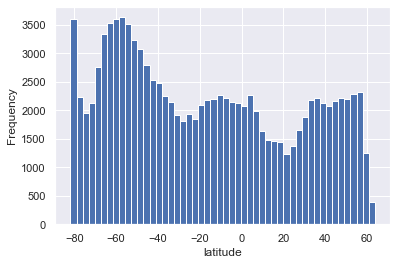

In [619]:
df['latitude'].plot(kind='hist',bins=50)

plt.xlabel('latitude')

plt.show()

Remove pixels with latitude > 70:

In [620]:
df = df.loc[ abs( df['latitude'] ) < 70]

print('dataframe shape',df.shape)

dataframe shape (101483, 113)


In [621]:
df = df.sample(n=10000, random_state = 42)

### Create cloud phase & multilayer cloud labels <a class="anchor" id="labels"></a>

Using the cldclass-lidar product (corresponding to cloud_layer_source = 3) in the dataset, let's define monolayer and multilayer clouds labels that will be used to train the machine learning algorithm:

In [622]:
df['label 1'] = 'unlabeled'
df['label 2'] = 'unlabeled'

#print(df.head())

for index, row in df.iterrows():
    nb_cloud_layer = 0
    cloud_phase_per_layer_list = []
    for layer_idx in range(10):
        if int( row['cloud_layer_source_{:02d}'.format(layer_idx+1)] ) == 3: # cldclass-lidar product
            cloud_phase_per_layer_list.append( int( row['cloud_layer_phase_{:02d}'.format(layer_idx+1)] ) )
            nb_cloud_layer = nb_cloud_layer + 1
    if nb_cloud_layer == 1: # monolayer cloud   
        df.loc[index,'label 1'] = 'monolayer (n=1)'
        if cloud_phase_per_layer_list[0] == 1: df.loc[index,'label 2'] = 'ice'
        if cloud_phase_per_layer_list[0] == 2: df.loc[index,'label 2'] = 'mixed'    
        if cloud_phase_per_layer_list[0] == 3: df.loc[index,'label 2'] = 'liquid'
    if nb_cloud_layer == 2: # multilayer cloud 
        df.loc[index,'label 1'] = 'multilayer (n=2)'
        if cloud_phase_per_layer_list[0] == 1 and cloud_phase_per_layer_list[1] == 1: 
            df.loc[index,'label 2'] = 'ice / ice'
        if cloud_phase_per_layer_list[0] == 1 and cloud_phase_per_layer_list[1] == 3: 
            df.loc[index,'label 2'] = 'ice / liquid'
        if cloud_phase_per_layer_list[0] == 1 and cloud_phase_per_layer_list[1] == 2: 
            df.loc[index,'label 2'] = 'ice / mixed'
        if cloud_phase_per_layer_list[0] == 3 and cloud_phase_per_layer_list[1] == 3: 
            df.loc[index,'label 2'] = 'liquid / liquid'
        if cloud_phase_per_layer_list[0] == 2 and cloud_phase_per_layer_list[1] == 3: 
            df.loc[index,'label 2'] = 'mixed / liquid'    
        if cloud_phase_per_layer_list[0] == 3 and cloud_phase_per_layer_list[1] == 1: 
            df.loc[index,'label 2'] = 'liquid / ice'
    if nb_cloud_layer > 2: # multilayer cloud 
        df.loc[index,'label 1'] = 'multilayer (n>2)'

In [623]:
df['label 1'].value_counts()

monolayer (n=1)     5842
multilayer (n=2)    2661
multilayer (n>2)    1079
unlabeled            418
Name: label 1, dtype: int64

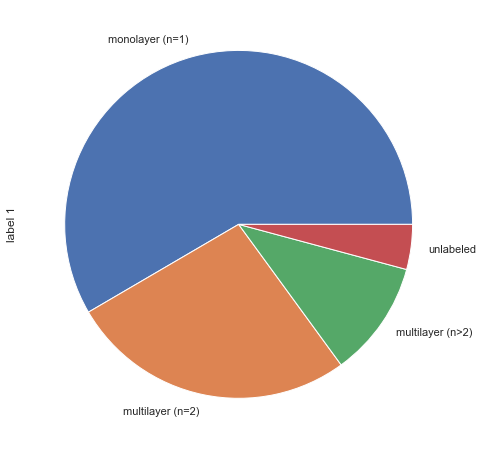

In [624]:
df['label 1'].value_counts().plot(kind='pie', figsize=(8, 8))

plt.show()

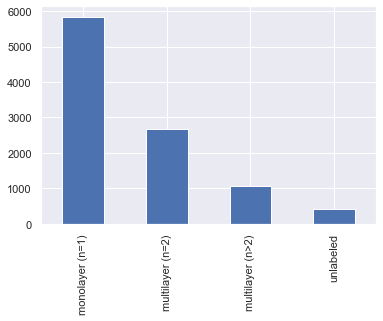

In [625]:
df['label 1'].value_counts().plot(kind='bar')

plt.show()

In [626]:
df['label 2'].value_counts()

liquid             2908
ice                1624
unlabeled          1560
mixed              1310
ice / liquid       1237
ice / mixed         479
ice / ice           452
liquid / liquid     271
mixed / liquid      151
liquid / ice          8
Name: label 2, dtype: int64

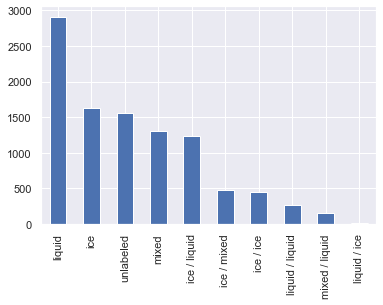

In [627]:
df['label 2'].value_counts().plot(kind='bar')

plt.show()

In [628]:
df.drop( df[(df['label 1'] == 'unlabeled' ) | (df['label 2'] == 'unlabeled')].index, inplace=True )

print(df.shape)

(8440, 115)


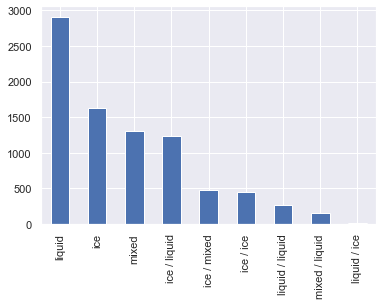

In [629]:
df['label 2'].value_counts().plot(kind='bar')

plt.savefig('output.png', bbox_inches='tight')
plt.show()

### Create a simple model that use only 2 modis bands <a class="anchor" id="simple_case"></a>

In [630]:
sub_dataset = df[ ['modis_band_1','modis_band_7', 'label 2'] ] [ (df['label 2'] == 'liquid') | (df['label 2'] == 'ice') ]

train_dataset = sub_dataset.sample(frac=0.8,random_state=0)

test_dataset = sub_dataset.drop(train_dataset.index)

test_dataset

modis_band_1  modis_band_7 label 2
23625       0.121545      0.063265     ice
54012       0.196092      0.074602     ice
72033       0.377801      0.077946     ice
143305      0.184228      0.091218  liquid
9962        0.266254      0.208120  liquid
...              ...           ...     ...
24034       0.047854      0.015684     ice
44227       0.291430      0.159342  liquid
82145       0.182224      0.062771     ice
46418       0.075745      0.068562  liquid
151393      0.172504      0.089052     ice

[906 rows x 3 columns]

In [631]:
train_dataset_stats = train_dataset.describe()
train_dataset_stats = train_dataset_stats.transpose()
train_dataset_stats

count      mean       std       min       25%       50%  \
modis_band_1  3626.0  0.243452  0.164852  0.015472  0.106141  0.209122   
modis_band_7  3626.0  0.118082  0.076499  0.007092  0.052689  0.100444   

                   75%       max  
modis_band_1  0.347182  0.983303  
modis_band_7  0.175433  0.465181

In [632]:
train_dataset_labels = train_dataset.pop('label 2')
test_dataset_labels = test_dataset.pop('label 2')

In [633]:
train_dataset_labels[ train_dataset_labels == 'liquid'] = 0.0
train_dataset_labels[ train_dataset_labels == 'ice'] = 1.0

train_dataset_labels

107288    0
10352     1
112725    1
43185     1
56602     0
         ..
84542     1
109995    0
65572     1
16303     0
10812     0
Name: label 2, Length: 3626, dtype: object

In [634]:
test_dataset_labels[ test_dataset_labels == 'liquid'] = 0.0
test_dataset_labels[ test_dataset_labels == 'ice'] = 1.0

test_dataset_labels

23625     1
54012     1
72033     1
143305    0
9962      0
         ..
24034     1
44227     0
82145     1
46418     0
151393    1
Name: label 2, Length: 906, dtype: object

In [635]:
def norm(x):
  return (x - train_dataset_stats['mean']) / train_dataset_stats['std']

normed_train_dataset = norm(train_dataset)
normed_test_dataset = norm(test_dataset)

normed_train_dataset_stats = normed_train_dataset.describe()
normed_train_dataset_stats = normed_train_dataset_stats.transpose()
normed_train_dataset_stats

count          mean  std       min       25%       50%  \
modis_band_1  3626.0 -3.919155e-18  1.0 -1.382936 -0.832934 -0.208246   
modis_band_7  3626.0  9.797887e-18  1.0 -1.450879 -0.854826 -0.230567   

                   75%       max  
modis_band_1  0.629230  4.487962  
modis_band_7  0.749693  4.537309

In [636]:
print(train_dataset.shape)
print(type(train_dataset))

(3626, 2)
<class 'pandas.core.frame.DataFrame'>


In [637]:
print(normed_train_dataset.shape)

(3626, 2)


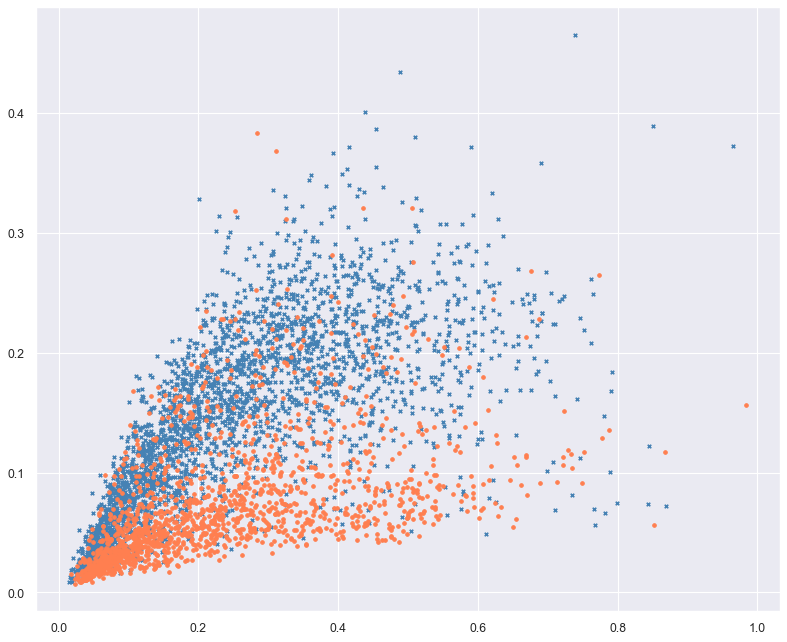

In [638]:
df_monolayer_liquid = df.loc[df['label 2'] == 'liquid']
df_monolayer_ice = df.loc[df['label 2'] == 'ice']

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(df_monolayer_liquid['modis_band_1'], df_monolayer_liquid['modis_band_7'], s=10, c='steelblue', marker = 'x', label="CloudSat-Caliop: Liquid cloud phase")
plt.scatter(df_monolayer_ice['modis_band_1'], df_monolayer_ice['modis_band_7'], s=10, c='coral', marker = 'o', label="CloudSat-Caliop: Ice cloud phase")

plt.show()
plt.close()

In [639]:
def build_model():
    model = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [640]:
model = build_model()

In [641]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_58 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [642]:
model.fit(normed_train_dataset, train_dataset_labels, epochs=400, batch_size=400, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.6412,  loss:0.6841,  
....................................................................................................
Epoch: 100, accuracy:0.8434,  loss:0.4585,  
....................................................................................................
Epoch: 200, accuracy:0.8434,  loss:0.4312,  
....................................................................................................
Epoch: 300, accuracy:0.8442,  loss:0.4225,  
....................................................................................................

In [643]:
print(train_dataset.shape)

train_dataset

(3626, 2)


modis_band_1  modis_band_7
107288      0.080915      0.037416
10352       0.179174      0.048637
112725      0.174535      0.029450
43185       0.064298      0.030232
56602       0.136541      0.090690
...              ...           ...
84542       0.050598      0.019513
109995      0.119979      0.159746
65572       0.234993      0.054175
16303       0.158686      0.137400
10812       0.476642      0.244656

[3626 rows x 2 columns]

In [644]:
x1, x2 = np.meshgrid(np.arange(0.0,1.0, 0.001), np.arange(0.0,0.5, 0.001))

print(x1.shape)

print(x1.flatten())
print(x2.flatten())

gridded_test = np.stack((x1.flatten(),x2.flatten()),axis=-1)

print(gridded_test)

print(gridded_test.shape)

(500, 1000)
[0.    0.001 0.002 ... 0.997 0.998 0.999]
[0.    0.    0.    ... 0.499 0.499 0.499]
[[0.    0.   ]
 [0.001 0.   ]
 [0.002 0.   ]
 ...
 [0.997 0.499]
 [0.998 0.499]
 [0.999 0.499]]
(500000, 2)


In [645]:
gridded_test = pd.DataFrame(data=gridded_test, columns=['modis_band_1','modis_band_7'])

normed_gridded_test = norm(gridded_test)

normed_gridded_test

modis_band_1  modis_band_7
0          -1.476788     -1.543580
1          -1.470722     -1.543580
2          -1.464656     -1.543580
3          -1.458590     -1.543580
4          -1.452524     -1.543580
...              ...           ...
499995      4.558915      4.979389
499996      4.564981      4.979389
499997      4.571047      4.979389
499998      4.577113      4.979389
499999      4.583179      4.979389

[500000 rows x 2 columns]

In [646]:
yhat = model.predict(normed_gridded_test)

In [647]:
yhat

array([[5.1313084e-01],
       [5.2201575e-01],
       [5.3088641e-01],
       ...,
       [8.4280968e-05],
       [8.3029270e-05],
       [8.1717968e-05]], dtype=float32)

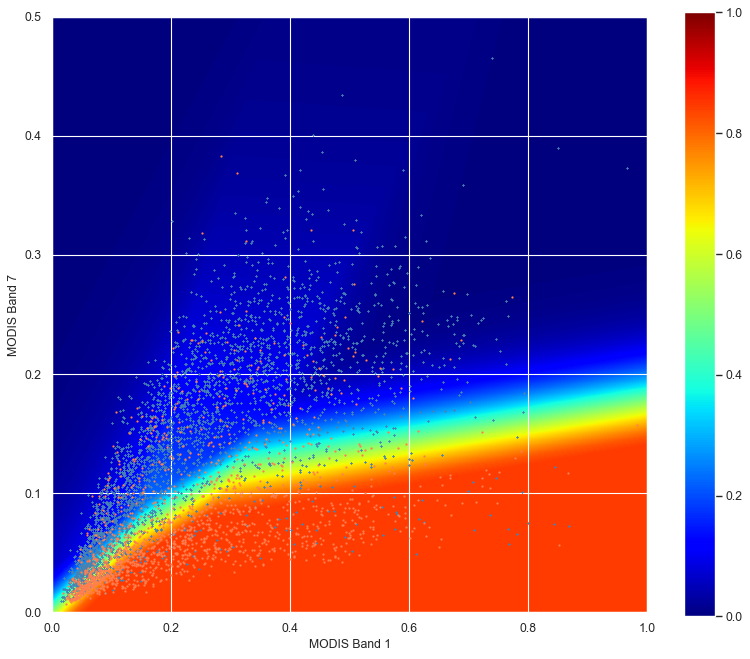

In [648]:
from pylab import figure, cm

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

ax = fig.add_subplot(111)

def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

img = plt.imshow(yhat.reshape(500,1000), cmap=cm.jet, origin='lower',extent=[0.0,1.0,0.0,0.5],vmin=0.0,vmax=1.0)

plt.scatter(df_monolayer_liquid['modis_band_1'], df_monolayer_liquid['modis_band_7'], s=1, c='steelblue', marker = 'x', label="CloudSat-Caliop: Liquid cloud phase")
plt.scatter(df_monolayer_ice['modis_band_1'], df_monolayer_ice['modis_band_7'], s=1, c='coral', marker = 'o', label="CloudSat-Caliop: Ice cloud phase")

plt.colorbar(img)

plt.xlabel('MODIS Band 1',fontsize=11)
plt.ylabel('MODIS Band 7',fontsize=11)

forceAspect(ax,aspect=1.0)

plt.show()

### How to select features that will be used to train DL models ?  <a class="anchor" id="select_input_features"></a>

In [649]:
features_list = ['modis_band_1','modis_band_7','modis_band_20',
                 'modis_band_26','modis_band_28','modis_band_29',
                 'modis_band_31','modis_band_32']

sub_dataset = df[features_list + ['label 2']]

### How to split the dataset into a training and testing dataset ?  <a class="anchor" id="split_train_and_test_datasets"></a>

In [650]:
train_dataset = sub_dataset.sample(frac=0.8,random_state=0)

test_dataset = sub_dataset.drop(train_dataset.index)

test_dataset

modis_band_1  modis_band_7  modis_band_20  modis_band_26  \
23625       0.121545      0.063265       0.168468       0.062168   
74403       0.072404      0.073994       0.584660       0.001681   
45369       0.174023      0.043167       0.251291       0.085529   
30688       0.116897      0.038544       0.091121       0.005178   
22397       0.149856      0.155394       0.691948       0.007789   
...              ...           ...            ...            ...   
132291      0.465708      0.127007       0.202568       0.022899   
113429      0.758348      0.186967       0.442857       0.008670   
57898       0.368833      0.171305       0.507798       0.000187   
108937      0.273708      0.152058       0.237637       0.005958   
126214      0.302477      0.210020       0.387411       0.039310   

        modis_band_28  modis_band_29  modis_band_31  modis_band_32  \
23625        1.538927       3.594860       4.173019       4.014662   
74403        3.039265       6.917314       7.601471       7.099782   
45369        1.495625       4.091222       4.867431       4.384099   
30688        1.706935       3.041675       3.964110       3.965555   
22397        2.362034       5.351905       6.115028       5.705967   
...               ...            ...            ...            ...   
132291       2.052767       3.877302       4.658522       4.578811   
113429       3.042536       6.245470       6.887536       6.560185   
57898        3.128369       6.380841       7.097747       6.757181   
108937       2.159577       4.380350       5.293059       5.186357   
126214       2.025440       3.504055       4.387786       4.293881   

                label 2  
23625               ice  
74403            liquid  
45369         ice / ice  
30688             mixed  
22397            liquid  
...                 ...  
132291      ice / mixed  
113429     ice / liquid  
57898   liquid / liquid  
108937            mixed  
126214           liquid  

[1688 rows x 9 columns]

### How to prepare the data ?  <a class="anchor" id="data_preparation"></a>

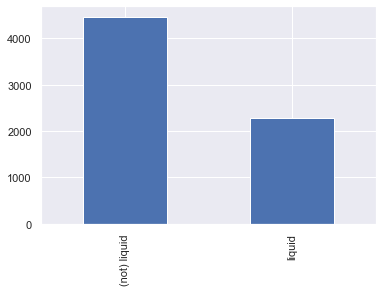

In [651]:
label_name = 'liquid'

train_dataset_prepared = train_dataset.copy()

test_dataset_prepared = test_dataset.copy()

train_dataset_prepared['label 2'][ train_dataset_prepared['label 2'] != label_name ] = '(not) ' + label_name

train_dataset_prepared['label 2'].value_counts().plot(kind='bar')

plt.show() 

In [652]:
t1 = train_dataset_prepared[ train_dataset_prepared['label 2'] == label_name  ]
t2 = train_dataset_prepared[ train_dataset_prepared['label 2'] != label_name  ]

ids = np.arange(len(t1))
choices = np.random.choice(ids, len(t2))

print(choices.shape)

t1 = t1.iloc[choices,:]

print( t1.shape )

t1

(4470,)
(4470, 9)


modis_band_1  modis_band_7  modis_band_20  modis_band_26  \
113310      0.110495      0.131768       0.456510       0.009581   
126578      0.192958      0.107965       0.225647       0.001497   
113075      0.311978      0.219205       0.721612       0.011825   
37292       0.051924      0.038213       0.365440       0.001330   
70342       0.111546      0.028357       0.123003       0.001681   
...              ...           ...            ...            ...   
61867       0.049450      0.042426       0.301955       0.001797   
4673        0.268956      0.166799       0.513135       0.005947   
118078      0.543695      0.178123       0.323024       0.016082   
33760       0.232294      0.117332       0.505372       0.001960   
138518      0.555431      0.205246       0.365024       0.009404   

        modis_band_28  modis_band_29  modis_band_31  modis_band_32 label 2  
113310       2.098570       4.083423       4.896066       4.629630  liquid  
126578       2.431316       4.470040       5.388076       5.277146  liquid  
113075       3.024061       6.068874       6.827662       6.466541  liquid  
37292        3.067747       6.596990       7.244829       6.748616  liquid  
70342        2.065661       3.457260       4.361103       4.329283  liquid  
...               ...            ...            ...            ...     ...  
61867        2.412648       6.050490       6.895997       6.540201  liquid  
4673         2.768103       5.516803       6.343461       6.061131  liquid  
118078       2.616838       4.859443       5.733655       5.572924  liquid  
33760        2.831611       6.354101       7.210987       6.789157  liquid  
138518       2.868754       5.125729       5.995279       5.819026  liquid  

[4470 rows x 9 columns]

In [653]:
train_dataset_prepared = pd.concat([t1, t2], axis=0)

train_dataset_prepared

modis_band_1  modis_band_7  modis_band_20  modis_band_26  \
113310      0.110495      0.131768       0.456510       0.009581   
126578      0.192958      0.107965       0.225647       0.001497   
113075      0.311978      0.219205       0.721612       0.011825   
37292       0.051924      0.038213       0.365440       0.001330   
70342       0.111546      0.028357       0.123003       0.001681   
...              ...           ...            ...            ...   
42004       0.096525      0.069227       0.435233       0.001563   
86891       0.202347      0.150409       0.281232       0.002405   
132832      0.067075      0.027187       0.170201       0.024672   
82796       0.099081      0.024329       0.059309       0.023904   
19236       0.296014      0.111344       0.212271       0.138441   

        modis_band_28  modis_band_29  modis_band_31  modis_band_32  \
113310       2.098570       4.083423       4.896066       4.629630   
126578       2.431316       4.470040       5.388076       5.277146   
113075       3.024061       6.068874       6.827662       6.466541   
37292        3.067747       6.596990       7.244829       6.748616   
70342        2.065661       3.457260       4.361103       4.329283   
...               ...            ...            ...            ...   
42004        3.112396       6.386412       7.147859       6.767459   
86891        2.207497       4.709587       5.621716       5.464434   
132832       1.889955       4.387034       5.073086       4.879158   
82796        1.514485       2.639459       3.424591       3.428243   
19236        1.166729       2.818284       3.205920       3.053096   

             label 2  
113310        liquid  
126578        liquid  
113075        liquid  
37292         liquid  
70342         liquid  
...              ...  
42004   (not) liquid  
86891   (not) liquid  
132832  (not) liquid  
82796   (not) liquid  
19236   (not) liquid  

[8940 rows x 9 columns]

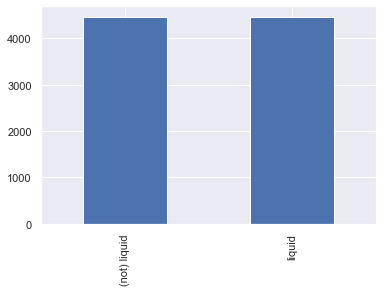

In [654]:
train_dataset_prepared['label 2'].value_counts().plot(kind='bar')

plt.show() 

In [655]:
train_dataset_prepared_labels = train_dataset_prepared.pop('label 2')
test_dataset_prepared_labels = test_dataset_prepared.pop('label 2')

In [656]:
train_dataset_prepared_labels[ train_dataset_prepared_labels != label_name] = 0.0
train_dataset_prepared_labels[ train_dataset_prepared_labels == label_name] = 1.0

train_dataset_prepared_labels

113310    1
126578    1
113075    1
37292     1
70342     1
         ..
42004     0
86891     0
132832    0
82796     0
19236     0
Name: label 2, Length: 8940, dtype: object

In [657]:
test_dataset_prepared_labels[ test_dataset_prepared_labels != label_name] = 0.0
test_dataset_prepared_labels[ test_dataset_prepared_labels == label_name] = 1.0

test_dataset_prepared_labels

23625     0
74403     1
45369     0
30688     0
22397     1
         ..
132291    0
113429    0
57898     0
108937    0
126214    1
Name: label 2, Length: 1688, dtype: object

In [658]:
train_dataset_prepared_stats = train_dataset_prepared.describe()
train_dataset_prepared_stats = train_dataset_prepared_stats.transpose()
train_dataset_prepared_stats

count      mean       std       min       25%       50%  \
modis_band_1   8940.0  0.262427  0.177633  0.015472  0.114366  0.224570   
modis_band_7   8940.0  0.124061  0.074419  0.007092  0.059442  0.112941   
modis_band_20  8940.0  0.384700  0.215452  0.025071  0.209533  0.385366   
modis_band_26  8940.0  0.032533  0.062425 -0.005887  0.001983  0.008903   
modis_band_28  8940.0  2.469334  0.767391  0.223148  1.947497  2.465861   
modis_band_29  8940.0  5.108568  1.834780  0.441203  3.741234  5.096761   
modis_band_31  8940.0  5.835840  1.777648  0.849347  4.549674  5.902865   
modis_band_32  8940.0  5.566135  1.578333  0.960947  4.437060  5.663143   

                    75%        max  
modis_band_1   0.371132   1.054874  
modis_band_7   0.182061   0.465181  
modis_band_20  0.529075   1.432776  
modis_band_26  0.034161   0.613926  
modis_band_28  3.047492   4.473207  
modis_band_29  6.661751  10.168461  
modis_band_31  7.335291  10.263924  
modis_band_32  6.908496   8.981802

In [659]:
def scaled_data(x):
  return (x - train_dataset_prepared_stats['mean']) / train_dataset_prepared_stats['std']

In [660]:
train_dataset_prepared = scaled_data(train_dataset_prepared)

test_stats = train_dataset_prepared.describe()
test_stats = test_stats.transpose()
test_stats

count          mean  std       min       25%       50%  \
modis_band_1   8940.0  1.271665e-17  1.0 -1.390260 -0.833524 -0.213119   
modis_band_7   8940.0 -8.901654e-17  1.0 -1.571767 -0.868306 -0.149424   
modis_band_20  8940.0  6.358324e-17  1.0 -1.669181 -0.813020  0.003092   
modis_band_26  8940.0 -3.179162e-17  1.0 -0.615453 -0.489376 -0.378537   
modis_band_28  8940.0 -5.722492e-17  1.0 -2.927041 -0.680013 -0.004525   
modis_band_29  8940.0 -1.653164e-16  1.0 -2.543829 -0.745231 -0.006435   
modis_band_31  8940.0  1.080915e-16  1.0 -2.805107 -0.723521  0.037705   
modis_band_32  8940.0 -1.589581e-16  1.0 -2.917754 -0.715359  0.061462   

                    75%       max  
modis_band_1   0.611967  4.461155  
modis_band_7   0.779378  4.583799  
modis_band_20  0.670103  4.864538  
modis_band_26  0.026077  9.313420  
modis_band_28  0.753408  2.611281  
modis_band_29  0.846523  2.757766  
modis_band_31  0.843503  2.490980  
modis_band_32  0.850493  2.164097

In [661]:
test_dataset_prepared = scaled_data(test_dataset_prepared)

test_dataset_prepared_stats = test_dataset_prepared.describe()
test_dataset_prepared_stats = test_dataset_prepared_stats.transpose()
test_dataset_prepared_stats

count      mean       std       min       25%       50%  \
modis_band_1   1688.0  0.079241  1.008612 -1.387366 -0.759998 -0.106935   
modis_band_7   1688.0 -0.021280  0.991586 -1.546080 -0.865883 -0.157454   
modis_band_20  1688.0 -0.143068  0.987353 -1.661783 -1.024768 -0.156463   
modis_band_26  1688.0  0.088527  1.100500 -0.641790 -0.478756 -0.333050   
modis_band_28  1688.0 -0.157745  0.995987 -2.784345 -0.858823 -0.193241   
modis_band_29  1688.0 -0.150359  1.002129 -2.456993 -0.921333 -0.217303   
modis_band_31  1688.0 -0.152239  1.006591 -2.667818 -0.908130 -0.157796   
modis_band_32  1688.0 -0.152411  1.008895 -2.752061 -0.917682 -0.157231   

                    75%       max  
modis_band_1   0.743911  4.058242  
modis_band_7   0.700415  4.169381  
modis_band_20  0.552769  3.675595  
modis_band_26  0.174104  9.912839  
modis_band_28  0.592717  2.457299  
modis_band_29  0.675354  2.128655  
modis_band_31  0.692210  1.866403  
modis_band_32  0.718355  1.806302

Now let's gather everything we have done in a simple function:

In [662]:
def data_preparation(train_dataset, test_dataset, label_name):

    #----- create labels -----#
    
    train_dataset_prepared = train_dataset.copy()

    test_dataset_prepared = test_dataset.copy()

    train_dataset_prepared['label 2'][ train_dataset_prepared['label 2'] != label_name ] = '(not) ' + label_name

    #----- upsampling -----#
    
    t1 = train_dataset_prepared[ train_dataset_prepared['label 2'] == label_name  ]
    t2 = train_dataset_prepared[ train_dataset_prepared['label 2'] != label_name  ]

    ids = np.arange(len(t1))
    choices = np.random.choice(ids, len(t2))

    t1 = t1.iloc[choices,:]

    train_dataset_prepared = pd.concat([t1, t2], axis=0)

    #----- labels encoding  -----#
    
    train_dataset_prepared_labels = train_dataset_prepared.pop('label 2')
    test_dataset_prepared_labels = test_dataset_prepared.pop('label 2')    

    train_dataset_prepared_labels[ train_dataset_prepared_labels != label_name] = 0.0
    train_dataset_prepared_labels[ train_dataset_prepared_labels == label_name] = 1.0

    test_dataset_prepared_labels[ test_dataset_prepared_labels != label_name] = 0.0
    test_dataset_prepared_labels[ test_dataset_prepared_labels == label_name] = 1.0

    #----- data scaling -----#

    train_dataset_prepared_stats = train_dataset_prepared.describe()
    train_dataset_prepared_stats = train_dataset_prepared_stats.transpose()

    def scaled_data(x):
      return (x - train_dataset_prepared_stats['mean']) / train_dataset_prepared_stats['std']    

    train_dataset_prepared = scaled_data(train_dataset_prepared)

    test_dataset_prepared = scaled_data(test_dataset_prepared)

    return train_dataset_prepared, train_dataset_prepared_labels, test_dataset_prepared, test_dataset_prepared_labels, scaled_data
        
liquid_train_dataset_prepared, liquid_train_dataset_prepared_labels, liquid_test_dataset_prepared, liquid_test_dataset_prepared_labels, liquid_scaled_data = data_preparation(train_dataset, test_dataset, label_name = 'liquid')   

Quick check if everything works as expected:

In [400]:
test_stats = liquid_train_dataset_prepared.describe()
test_stats = test_stats.transpose()
test_stats

count          mean  std       min       25%       50%  \
modis_band_1   8940.0 -1.684956e-16  1.0 -1.386258 -0.831183 -0.214388   
modis_band_7   8940.0 -1.907497e-17  1.0 -1.568432 -0.865002 -0.140844   
modis_band_20  8940.0  1.017332e-16  1.0 -1.665834 -0.830783  0.007502   
modis_band_26  8940.0 -6.358324e-18  1.0 -0.615895 -0.489875 -0.375587   
modis_band_28  8940.0 -1.017332e-16  1.0 -2.923537 -0.676919 -0.001983   
modis_band_29  8940.0 -2.161830e-16  1.0 -2.538751 -0.749443 -0.002460   
modis_band_31  8940.0  1.780331e-16  1.0 -2.798155 -0.725932  0.043777   
modis_band_32  8940.0 -1.017332e-16  1.0 -2.911315 -0.718381  0.063186   

                    75%       max  
modis_band_1   0.609972  4.458062  
modis_band_7   0.765963  3.963364  
modis_band_20  0.686683  4.902363  
modis_band_26  0.021877  9.279438  
modis_band_28  0.747583  2.639697  
modis_band_29  0.843782  2.773572  
modis_band_31  0.846099  2.502778  
modis_band_32  0.854624  2.176705

In [390]:
liquid_test_dataset_prepared_stats = liquid_test_dataset_prepared.describe()
liquid_test_dataset_prepared_stats = liquid_test_dataset_prepared_stats.transpose()
liquid_test_dataset_prepared_stats

count      mean       std       min       25%       50%  \
modis_band_1   1688.0  0.079669  1.001482 -1.376570 -0.753637 -0.105190   
modis_band_7   1688.0 -0.018336  0.986879 -1.535898 -0.858930 -0.153863   
modis_band_20  1688.0 -0.144630  0.992867 -1.671826 -1.031254 -0.158100   
modis_band_26  1688.0  0.090216  1.102983 -0.641749 -0.478347 -0.332313   
modis_band_28  1688.0 -0.164325  0.997630 -2.795260 -0.866559 -0.199879   
modis_band_29  1688.0 -0.154572  1.004758 -2.467259 -0.927570 -0.221692   
modis_band_31  1688.0 -0.157473  1.008329 -2.677395 -0.914669 -0.163040   
modis_band_32  1688.0 -0.158110  1.010147 -2.760987 -0.924331 -0.162937   

                    75%       max  
modis_band_1   0.739641  4.030541  
modis_band_7   0.699934  4.152433  
modis_band_20  0.555093  3.695360  
modis_band_26  0.175986  9.936699  
modis_band_28  0.587376  2.455036  
modis_band_29  0.673307  2.130422  
modis_band_31  0.688434  1.864654  
modis_band_32  0.713736  1.803033

### How to build a model ?  <a class="anchor" id="build_model"></a>

In [666]:
def build_model(input_dataset):
    model = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=[len(input_dataset.keys())]),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = build_model(liquid_train_dataset_prepared)

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_61 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 5         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [394]:
model.fit(liquid_train_dataset_prepared, liquid_train_dataset_prepared_labels, epochs=600, batch_size=400, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.5001,  loss:0.6756,  
....................................................................................................
Epoch: 100, accuracy:0.8018,  loss:0.4600,  
....................................................................................................
Epoch: 200, accuracy:0.8142,  loss:0.4374,  
....................................................................................................
Epoch: 300, accuracy:0.8176,  loss:0.4313,  
....................................................................................................
Epoch: 400, accuracy:0.8189,  loss:0.4282,  
....................................................................................................
Epoch: 500, accuracy:0.8219,  loss:0.4248,  
....................................................................................................

In [395]:
yhat = model.predict(test_dataset_prepared)

In [396]:
yhat

array([[0.03231019],
       [0.87874913],
       [0.08737844],
       ...,
       [0.85502386],
       [0.24748874],
       [0.19027361]], dtype=float32)

In [397]:
ytrue  = test_dataset_prepared_labels.to_numpy()
ytrue = ytrue.reshape(-1,1)

In [398]:
m = tf.keras.metrics.AUC(num_thresholds=3)

m.update_state(list(ytrue), list(yhat))

m.result().numpy()

0.81961817

### How to create a model to detect monolayer liquid cloud ? <a class="anchor" id="monolayer_liquid"></a>

In [667]:
liquid_train_dataset_prepared, liquid_train_dataset_prepared_labels, liquid_test_dataset_prepared, liquid_test_dataset_prepared_labels, liquid_scaled_data = data_preparation(train_dataset, test_dataset, label_name = 'liquid')   

monolayer_liquid_model = build_model(liquid_train_dataset_prepared)

monolayer_liquid_model.fit(liquid_train_dataset_prepared, liquid_train_dataset_prepared_labels, epochs=600, batch_size=400, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.4214,  loss:0.7136,  
....................................................................................................
Epoch: 100, accuracy:0.8027,  loss:0.4611,  
....................................................................................................
Epoch: 200, accuracy:0.8105,  loss:0.4515,  
....................................................................................................
Epoch: 300, accuracy:0.8145,  loss:0.4470,  
....................................................................................................
Epoch: 400, accuracy:0.8179,  loss:0.4404,  
....................................................................................................
Epoch: 500, accuracy:0.8239,  loss:0.4347,  
....................................................................................................

In [668]:
monolayer_liquid_model.evaluate(liquid_test_dataset_prepared, liquid_test_dataset_prepared_labels, batch_size=128)

1688/1688 [==============================] - 0s 83us/sample - loss: 0.4267 - accuracy: 0.8252


[0.4266851742120716, 0.825237]

### How to create a model to detect monolayer ice cloud ? <a class="anchor" id="monolayer_ice"></a>

In [404]:
ice_train_dataset_prepared, ice_train_dataset_prepared_labels, ice_test_dataset_prepared, ice_scaled_data = data_preparation(train_dataset, test_dataset, label_name = 'ice')   

monolayer_ice_model = build_model(ice_train_dataset_prepared)

monolayer_ice_model.fit(ice_train_dataset_prepared, ice_train_dataset_prepared_labels, epochs=600, batch_size=400, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.6696,  loss:0.6635,  
....................................................................................................
Epoch: 100, accuracy:0.7914,  loss:0.4742,  
....................................................................................................
Epoch: 200, accuracy:0.7939,  loss:0.4684,  
....................................................................................................
Epoch: 300, accuracy:0.7985,  loss:0.4651,  
....................................................................................................
Epoch: 400, accuracy:0.8011,  loss:0.4618,  
....................................................................................................
Epoch: 500, accuracy:0.8023,  loss:0.4600,  
....................................................................................................

### How to create a model to detect monolayer mixed cloud ? <a class="anchor" id="monolayer_mixed"></a>

In [414]:
mixed_train_dataset_prepared, mixed_train_dataset_prepared_labels, mixed_test_dataset_prepared, mixed_scaled_data = data_preparation(train_dataset, test_dataset, label_name = 'mixed')   

monolayer_mixed_model = build_model(mixed_train_dataset_prepared)

monolayer_mixed_model.fit(mixed_train_dataset_prepared,mixed_train_dataset_prepared_labels, epochs=600, batch_size=400, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.5196,  loss:0.8411,  
....................................................................................................
Epoch: 100, accuracy:0.7392,  loss:0.5392,  
....................................................................................................
Epoch: 200, accuracy:0.7455,  loss:0.5258,  
....................................................................................................
Epoch: 300, accuracy:0.7527,  loss:0.5194,  
....................................................................................................
Epoch: 400, accuracy:0.7522,  loss:0.5161,  
....................................................................................................
Epoch: 500, accuracy:0.7532,  loss:0.5136,  
....................................................................................................

### How to create a model to detect multilayer ice over liquid cloud ? <a class="anchor" id="multilayer_ice_over_liquid"></a>

In [419]:
ice_liquid_train_dataset_prepared, ice_liquid_train_dataset_prepared_labels, ice_liquid_test_dataset_prepared, ice_liquid_scaled_data = data_preparation(train_dataset, test_dataset, label_name = 'ice / liquid')   

multilayer_ice_liquid_model = build_model(ice_liquid_train_dataset_prepared)

multilayer_ice_liquid_model.fit(ice_liquid_train_dataset_prepared,ice_liquid_train_dataset_prepared_labels, epochs=600, batch_size=400, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.5150,  loss:0.7149,  
....................................................................................................
Epoch: 100, accuracy:0.6563,  loss:0.6219,  
....................................................................................................
Epoch: 200, accuracy:0.6698,  loss:0.6079,  
....................................................................................................
Epoch: 300, accuracy:0.6718,  loss:0.6025,  
....................................................................................................
Epoch: 400, accuracy:0.6748,  loss:0.5979,  
....................................................................................................
Epoch: 500, accuracy:0.6786,  loss:0.5961,  
....................................................................................................

### How to create a model to detect multilayer ice over mixed cloud ? <a class="anchor" id="multilayer_ice_over_mixed"></a>

In [423]:
ice_mixed_train_dataset_prepared, ice_mixed_train_dataset_prepared_labels, ice_mixed_test_dataset_prepared, ice_mixed_scaled_data = data_preparation(train_dataset, test_dataset, label_name = 'ice / mixed')   

multilayer_ice_mixed_model = build_model(ice_mixed_train_dataset_prepared)

multilayer_ice_mixed_model.fit(ice_mixed_train_dataset_prepared,ice_mixed_train_dataset_prepared_labels, epochs=600, batch_size=400, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.5340,  loss:0.6837,  
....................................................................................................
Epoch: 100, accuracy:0.7201,  loss:0.5453,  
....................................................................................................
Epoch: 200, accuracy:0.7263,  loss:0.5409,  
....................................................................................................
Epoch: 300, accuracy:0.7331,  loss:0.5396,  
....................................................................................................
Epoch: 400, accuracy:0.7340,  loss:0.5388,  
....................................................................................................
Epoch: 500, accuracy:0.7324,  loss:0.5368,  
....................................................................................................

### How to create a model to detect multilayer ice over ice cloud ? <a class="anchor" id="multilayer_ice_over_ice"></a>

In [424]:
ice_ice_train_dataset_prepared, ice_ice_train_dataset_prepared_labels, ice_ice_test_dataset_prepared, ice_ice_scaled_data = data_preparation(train_dataset, test_dataset, label_name = 'ice / ice')   

multilayer_ice_ice_model = build_model(ice_ice_train_dataset_prepared)

multilayer_ice_ice_model.fit(ice_ice_train_dataset_prepared,ice_ice_train_dataset_prepared_labels, epochs=600, batch_size=400, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.5894,  loss:0.6564,  
....................................................................................................
Epoch: 100, accuracy:0.7676,  loss:0.5045,  
....................................................................................................
Epoch: 200, accuracy:0.7783,  loss:0.4977,  
....................................................................................................
Epoch: 300, accuracy:0.7814,  loss:0.4920,  
....................................................................................................
Epoch: 400, accuracy:0.7784,  loss:0.4896,  
....................................................................................................
Epoch: 500, accuracy:0.7792,  loss:0.4876,  
....................................................................................................

### How to create a model to detect multilayer liquid over liquid cloud ? <a class="anchor" id="multilayer_liquid_over_liquid"></a>

In [425]:
liquid_liquid_train_dataset_prepared, liquid_liquid_train_dataset_prepared_labels, liquid_liquid_test_dataset_prepared, liquid_liquid_scaled_data = data_preparation(train_dataset, test_dataset, label_name = 'liquid / liquid')   

multilayer_liquid_liquid_model = build_model(liquid_liquid_train_dataset_prepared)

multilayer_liquid_liquid_model.fit(liquid_liquid_train_dataset_prepared,liquid_liquid_train_dataset_prepared_labels, epochs=600, batch_size=400, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.5811,  loss:0.7150,  
....................................................................................................
Epoch: 100, accuracy:0.7412,  loss:0.5127,  
....................................................................................................
Epoch: 200, accuracy:0.7513,  loss:0.5029,  
....................................................................................................
Epoch: 300, accuracy:0.7551,  loss:0.4961,  
....................................................................................................
Epoch: 400, accuracy:0.7583,  loss:0.4854,  
....................................................................................................
Epoch: 500, accuracy:0.7573,  loss:0.4771,  
....................................................................................................

### How to apply a machine learning model to a single MODIS granule ? <a class="anchor" id="modis_granule"></a>

In this section, we will see how to develop an algorihtm to apply previous trained models to a single MODIS granule. For that we will use the following products: 

- MODIS MYD021KM L1
- MODIS MYD06 L2 Cloud Mask (to select only cloudy pixels to apply ML models)
- MODIS MYD06 L2 Cloud Phase (only to make some comparisons with the ML models)
- MODIS MYD06 L2 Multilayer Clouds (only to make some comparisons with the ML models)

In [343]:
myd021km_file = SD('../data/MYD021KM.A2008015.1435.006.2012066180438.hdf', SDC.READ)
myd06_file = SD('../data/MYD06_L2.A2008015.1435.006.2013342100940.hdf', SDC.READ)

In [344]:
def bits_stripping(bit_start,bit_count,value):
    bitmask=pow(2,bit_start+bit_count)-1
    return np.right_shift(np.bitwise_and(value,bitmask),bit_start)

def plot_MODIS_L2_Cloud_Mask_1km(cloud_mask_flag):
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    #cmap =  [(1.0,1.0,1.0)] + [(1.0, 0.0, 0.0)] + [(65.0/255,105.0/255,225.0/255)] + [(0.0,0.0,0.0)]
    #cmap = sns.mpl_palette("Set1", 4)
    cmap = sns.color_palette("RdBu", n_colors=4)
    cmap = mpl.colors.ListedColormap(cmap)
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    img = plt.imshow(np.fliplr(cloud_mask_flag), cmap=cmap, norm=norm,interpolation='none', origin='lower')
    cbar_bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    cbar_ticks = [ 0, 1, 2, 3]  
    cbar_labels = ['Confident Cloudy', 'Probably Cloudy','Probably Clear ','Confident Clear']  
    cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=cbar_bounds, ticks=cbar_ticks)
    cbar.ax.set_yticklabels(cbar_labels, fontsize=11)
    plt.title('MODIS MYD06 C6 Cloud Mask 1km', fontsize=11)
    l = [int(i) for i in np.linspace(0,data.shape[1],6)]
    plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )
    l = [int(i) for i in np.linspace(0,data.shape[0],9)]
    plt.yticks(l, l, rotation=0, fontsize=11 )
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.show()

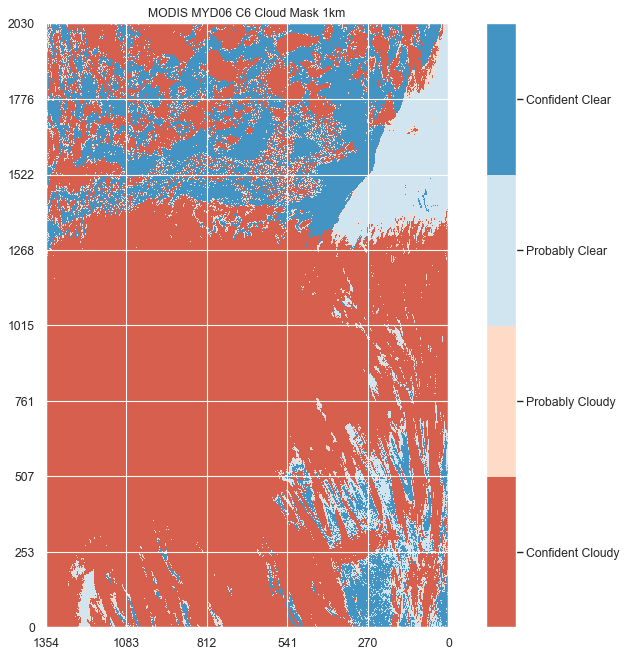

In [345]:
data_selected_id = myd06_file.select('Cloud_Mask_1km')
data = data_selected_id.get()   
cloud_mask_flag = bits_stripping(1,2,data[:,:,0])
plot_MODIS_L2_Cloud_Mask_1km(cloud_mask_flag)  

In [346]:
EV_250_Aggr1km_RefSB = myd021km_file.select('EV_250_Aggr1km_RefSB')
EV_500_Aggr1km_RefSB = myd021km_file.select('EV_500_Aggr1km_RefSB')
EV_1KM_RefSB = myd021km_file.select('EV_1KM_RefSB')
EV_1KM_Emissive = myd021km_file.select('EV_1KM_Emissive')

In [347]:
modis_band_dic = {}

In [348]:
#print( EV_250_Aggr1km_RefSB.info() )
EV_250_Aggr1km_RefSB_attributes = EV_250_Aggr1km_RefSB.attributes()
EV_250_Aggr1km_RefSB_scales = EV_250_Aggr1km_RefSB_attributes['reflectance_scales']
EV_250_Aggr1km_RefSB_offsets = EV_250_Aggr1km_RefSB_attributes['reflectance_offsets']
#pprint.pprint(EV_250_Aggr1km_RefSB_attributes )

for idx,i in enumerate(EV_250_Aggr1km_RefSB_attributes['band_names'].split(',')):
    print(idx,i)    
    modis_band_dic[i] = [EV_250_Aggr1km_RefSB,idx]

0 1
1 2


In [349]:
#print( EV_500_Aggr1km_RefSB.info() )
EV_500_Aggr1km_RefSB_attributes = EV_500_Aggr1km_RefSB.attributes()
EV_500_Aggr1km_RefSB_scales = EV_500_Aggr1km_RefSB_attributes['reflectance_scales']
EV_500_Aggr1km_RefSB_offsets = EV_500_Aggr1km_RefSB_attributes['reflectance_offsets']
#pprint.pprint(EV_500_Aggr1km_RefSB_attributes )

for idx,i in enumerate(EV_500_Aggr1km_RefSB_attributes['band_names'].split(',')):
    print(idx,i)
    modis_band_dic[i] = [EV_500_Aggr1km_RefSB,idx]

0 3
1 4
2 5
3 6
4 7


In [350]:
#print( EV_1KM_RefSB.info() )
EV_1KM_RefSB_attributes = EV_1KM_RefSB.attributes()
EV_1KM_RefSB_scales = EV_1KM_RefSB_attributes['reflectance_scales']
EV_1KM_RefSB_offsets = EV_1KM_RefSB_attributes['reflectance_offsets']
#pprint.pprint(EV_1KM_RefSB_attributes )

for idx,i in enumerate(EV_1KM_RefSB_attributes['band_names'].split(',')):
    print(idx,i)
    modis_band_dic[i] = [EV_1KM_RefSB,idx]

0 8
1 9
2 10
3 11
4 12
5 13lo
6 13hi
7 14lo
8 14hi
9 15
10 16
11 17
12 18
13 19
14 26


In [351]:
print( EV_1KM_Emissive.info() )
EV_1KM_Emissive_attributes = EV_1KM_Emissive.attributes()
EV_1KM_Emissive_scales = EV_1KM_Emissive_attributes['radiance_scales']
EV_1KM_Emissive_offsets = EV_1KM_Emissive_attributes['radiance_offsets']
#pprint.pprint(EV_1KM_Emissive_attributes )

for idx,i in enumerate(EV_1KM_Emissive_attributes['band_names'].split(',')):
    print(idx,i)
    modis_band_dic[i] = [EV_1KM_Emissive,idx]

('EV_1KM_Emissive', 3, [16, 2030, 1354], 23, 8)
0 20
1 21
2 22
3 23
4 24
5 25
6 27
7 28
8 29
9 30
10 31
11 32
12 33
13 34
14 35
15 36


In [352]:
for key in modis_band_dic:
    print(key, modis_band_dic[key][0].info()[0], modis_band_dic[key][1])

1 EV_250_Aggr1km_RefSB 0
2 EV_250_Aggr1km_RefSB 1
3 EV_500_Aggr1km_RefSB 0
4 EV_500_Aggr1km_RefSB 1
5 EV_500_Aggr1km_RefSB 2
6 EV_500_Aggr1km_RefSB 3
7 EV_500_Aggr1km_RefSB 4
8 EV_1KM_RefSB 0
9 EV_1KM_RefSB 1
10 EV_1KM_RefSB 2
11 EV_1KM_RefSB 3
12 EV_1KM_RefSB 4
13lo EV_1KM_RefSB 5
13hi EV_1KM_RefSB 6
14lo EV_1KM_RefSB 7
14hi EV_1KM_RefSB 8
15 EV_1KM_RefSB 9
16 EV_1KM_RefSB 10
17 EV_1KM_RefSB 11
18 EV_1KM_RefSB 12
19 EV_1KM_RefSB 13
26 EV_1KM_RefSB 14
20 EV_1KM_Emissive 0
21 EV_1KM_Emissive 1
22 EV_1KM_Emissive 2
23 EV_1KM_Emissive 3
24 EV_1KM_Emissive 4
25 EV_1KM_Emissive 5
27 EV_1KM_Emissive 6
28 EV_1KM_Emissive 7
29 EV_1KM_Emissive 8
30 EV_1KM_Emissive 9
31 EV_1KM_Emissive 10
32 EV_1KM_Emissive 11
33 EV_1KM_Emissive 12
34 EV_1KM_Emissive 13
35 EV_1KM_Emissive 14
36 EV_1KM_Emissive 15


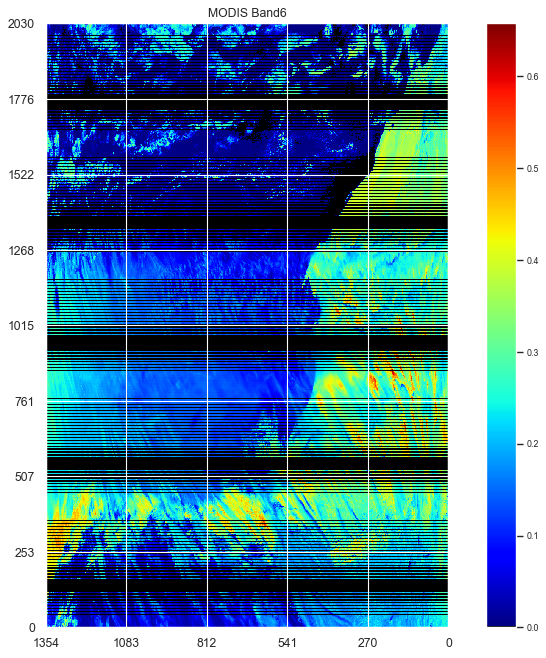

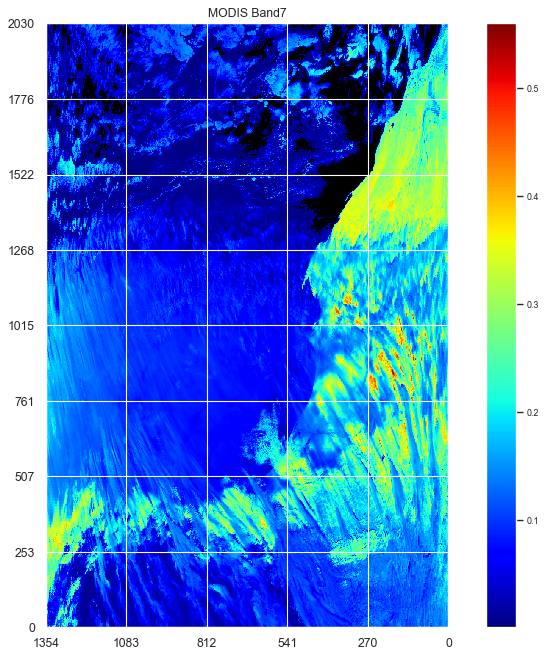

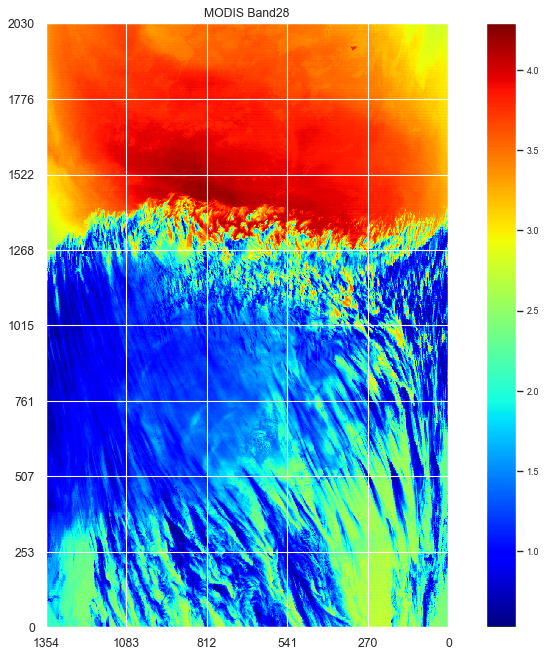

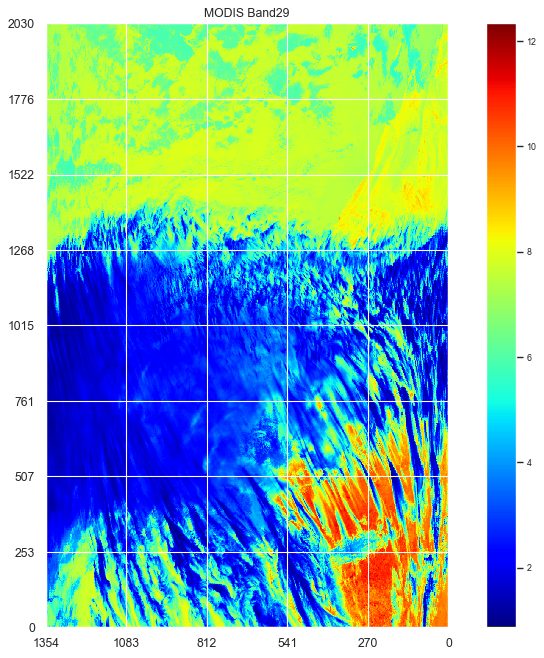

In [353]:
def plot_MODIS_L1(MODIS_band, modis_band_dic):

    data_selected_id = modis_band_dic[str(MODIS_band)][0]
    band_idx = modis_band_dic[str(MODIS_band)][1]
    title = 'MODIS Band' + str(MODIS_band)
    
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

    data = data_selected_id.get()
    data_selected_band = data[band_idx,:,:]
    data_selected_attributes = data_selected_id.attributes()
    _FillValue = data_selected_attributes['_FillValue']
    _FillValue = 65528 # warning wrong _FillValue stored in attributes    

    if modis_band_dic[str(MODIS_band)][0].info()[0] == 'EV_1KM_Emissive':
    
        radiance_scales = data_selected_attributes['radiance_scales']
        radiance_offsets = data_selected_attributes['radiance_offsets']
        data_selected_band[ data_selected_band == _FillValue ] = 0.0
        data_selected_band = (data_selected_band - radiance_offsets[band_idx]) * radiance_scales[band_idx]    
    
    else:
    
        reflectance_scales = data_selected_attributes['reflectance_scales']
        data_selected_band[ data_selected_band == _FillValue ] = 0.0
        data_selected_band = data_selected_band * reflectance_scales[band_idx]

    cmap = [(0.0,0.0,0.0)] + [(cm.jet(i)) for i in range(1,256)] 
    cmap = mpl.colors.ListedColormap(cmap)
    img = plt.imshow(np.fliplr(data_selected_band), cmap=cmap,interpolation='none', origin='lower')
    plt.title(title, fontsize=11)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8)
    l = [int(i) for i in np.linspace(0,data_selected_band.shape[1],6)]
    plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )
    l = [int(i) for i in np.linspace(0,data_selected_band.shape[0],9)]
    plt.yticks(l, l, rotation=0, fontsize=11 )
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)    
    plt.show()
    
plot_MODIS_L1(6,modis_band_dic)
plot_MODIS_L1(7,modis_band_dic)
plot_MODIS_L1(28,modis_band_dic)
plot_MODIS_L1(29,modis_band_dic)

(5,)


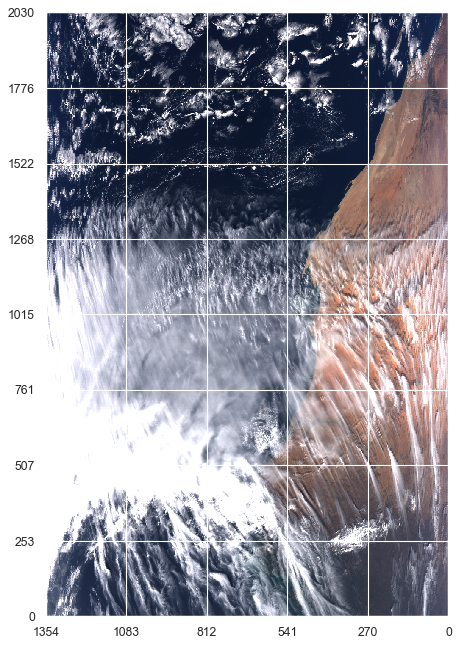

In [384]:
def plot_RGB_image(myd021km_file):

    selected_sds = myd021km_file.select('EV_250_Aggr1km_RefSB')

    selected_sds_attributes = selected_sds.attributes()

    for key, value in selected_sds_attributes.items():
        if key == 'reflectance_scales':
            reflectance_scales_250_Aggr1km_RefSB = np.asarray(value)
        if key == 'reflectance_offsets':
            reflectance_offsets_250_Aggr1km_RefSB = np.asarray(value)

    sds_data_250_Aggr1km_RefSB = selected_sds.get()




    selected_sds = myd021km_file.select('EV_500_Aggr1km_RefSB')

    selected_sds_attributes = selected_sds.attributes()

    for key, value in selected_sds_attributes.items():
        if key == 'reflectance_scales':
            reflectance_scales_500_Aggr1km_RefSB = np.asarray(value)
        if key == 'reflectance_offsets':
            reflectance_offsets_500_Aggr1km_RefSB = np.asarray(value)

    sds_data_500_Aggr1km_RefSB = selected_sds.get()

    print( reflectance_scales_500_Aggr1km_RefSB.shape)


    data_shape = sds_data_250_Aggr1km_RefSB.shape

    along_track = data_shape[1]
    cross_trak = data_shape[2]

    z = np.zeros((along_track, cross_trak,3))

    z[:,:,0] = ( sds_data_250_Aggr1km_RefSB[0,:,:] - reflectance_offsets_250_Aggr1km_RefSB[0] ) * reflectance_scales_250_Aggr1km_RefSB[0] 
    z[:,:,1] = ( sds_data_500_Aggr1km_RefSB[1,:,:] - reflectance_offsets_500_Aggr1km_RefSB[1] ) * reflectance_scales_500_Aggr1km_RefSB[1] 
    z[:,:,2] = ( sds_data_500_Aggr1km_RefSB[0,:,:] - reflectance_offsets_500_Aggr1km_RefSB[0] ) * reflectance_scales_500_Aggr1km_RefSB[0] 



    norme = 0.4 # factor to increase the brightness ]0,1]

    rgb = np.zeros((along_track, cross_trak,3))

    rgb = z / norme

    rgb[ rgb > 1 ] = 1.0
    rgb[ rgb < 0 ] = 0.0

    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

    ax = fig.add_subplot(111)

    img = plt.imshow(np.fliplr(rgb), interpolation='nearest', origin='lower')

    l = [int(i) for i in np.linspace(0,cross_trak,6)]
    plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )

    l = [int(i) for i in np.linspace(0,along_track,9)]
    plt.yticks(l, l, rotation=0, fontsize=11 )

    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.title('', fontsize=16)

    plt.show()

    plt.close()
    
plot_RGB_image(myd021km_file)

In [354]:
A = np.argwhere( cloud_mask_flag < 2 ) # cloudy pixels
row = A[:,0]
col = A[:,1]

def select_cloudy_pixel_only(data):
    data_masked = ma.masked_where( cloud_mask_flag > 1, data)
    return np.ma.compressed(data_masked)

In [355]:
EV_250_Aggr1km_RefSB_data = EV_250_Aggr1km_RefSB.get()
EV_500_Aggr1km_RefSB_data = EV_500_Aggr1km_RefSB.get()
EV_1KM_RefSB_data = EV_1KM_RefSB.get()
EV_1KM_Emissive_data = EV_1KM_Emissive.get()

In [356]:
def vectorize_modis_l1(features_train, modis_band_dic):
    
    X_list = []
    
    for feature in features_train:
    
        modis_band = feature.replace('modis_band_','')  
        modis_band_idx = modis_band_dic[modis_band][1]
        
        if modis_band_dic[modis_band][0].info()[0] == 'EV_250_Aggr1km_RefSB':
            data_band = EV_250_Aggr1km_RefSB_data[modis_band_idx,:,:]
            data_band = (data_band - EV_250_Aggr1km_RefSB_offsets[modis_band_idx]) * EV_250_Aggr1km_RefSB_scales[modis_band_idx]
  
        if modis_band_dic[modis_band][0].info()[0] == 'EV_500_Aggr1km_RefSB':
            data_band = EV_500_Aggr1km_RefSB_data[modis_band_idx,:,:]
            data_band = (data_band - EV_500_Aggr1km_RefSB_offsets[modis_band_idx]) * EV_500_Aggr1km_RefSB_scales[modis_band_idx]
            
        if modis_band_dic[modis_band][0].info()[0] == 'EV_1KM_RefSB':
            data_band = EV_1KM_RefSB_data[modis_band_idx,:,:]
            data_band = (data_band - EV_1KM_RefSB_scales[modis_band_idx]) * EV_1KM_RefSB_scales[modis_band_idx]
            
        if modis_band_dic[modis_band][0].info()[0] == 'EV_1KM_Emissive':
            data_band = EV_1KM_Emissive_data[modis_band_idx,:,:] 
            data_band = (data_band - EV_1KM_Emissive_offsets[modis_band_idx]) * EV_1KM_Emissive_scales[modis_band_idx]

        X_list.append( select_cloudy_pixel_only(data_band) )
        
    return np.stack(X_list, axis=-1)

In [405]:
features_train = ['modis_band_1','modis_band_7','modis_band_20',
                  'modis_band_26','modis_band_28','modis_band_29',
                  'modis_band_31','modis_band_32']

X = vectorize_modis_l1(features_train, modis_band_dic)

print(X.shape)

(2016074, 8)


In [406]:
X = pd.DataFrame(data=X, columns=features_train)

X_scaled = liquid_scaled_data(X)

In [407]:
%%time

monolayer_liquid_model_y_prob = monolayer_liquid_model.predict(X_scaled)

CPU times: user 41.2 s, sys: 2.29 s, total: 43.5 s
Wall time: 31.3 s


In [408]:
def plot_y_prob(data, title):

    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
        
    cmap = [(0.0,0.0,0.0)] + [(cm.RdBu_r(i)) for i in range(1,256)] 
    cmap = mpl.colors.ListedColormap(cmap)    
    
    img = plt.imshow(np.fliplr(data), cmap=cmap,interpolation='none', origin='lower', vmin=0.0, vmax=1.0)
    cbar = plt.colorbar(img, cmap=cmap)
    plt.title(title, fontsize=16)
    l = [int(i) for i in np.linspace(0,data.shape[1],6)]
    plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )
    l = [int(i) for i in np.linspace(0,data.shape[0],9)]
    plt.yticks(l, l, rotation=0, fontsize=11 )
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.show()

In [409]:
monolayer_liquid_model_y_prob.shape

(2016074, 1)

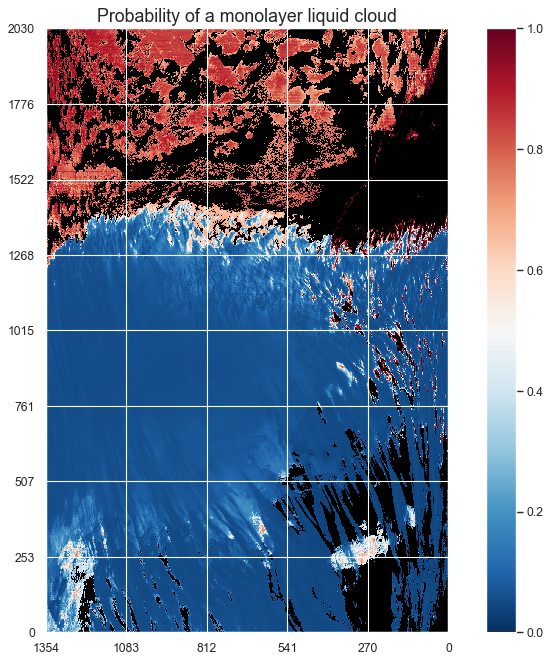

In [410]:
modis_y_prob = np.zeros((cloud_mask_flag.shape)) 
modis_y_prob[row,col] = monolayer_liquid_model_y_prob[:,0]
plot_y_prob(modis_y_prob, 'Probability of a monolayer liquid cloud')

In [411]:
X = pd.DataFrame(data=X, columns=features_train)

X_scaled = ice_scaled_data(X)

In [412]:
%%time

monolayer_ice_model_y_prob = monolayer_ice_model.predict(X_scaled)

CPU times: user 43.8 s, sys: 2.67 s, total: 46.5 s
Wall time: 32.7 s


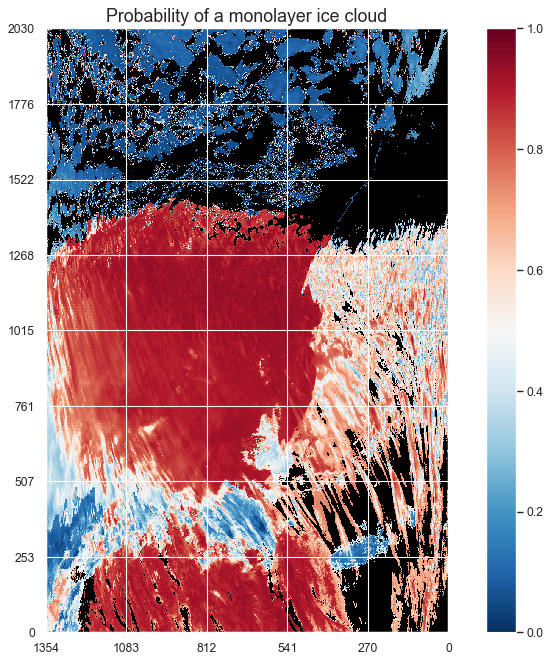

In [413]:
modis_y_prob = np.zeros((cloud_mask_flag.shape)) 
modis_y_prob[row,col] = monolayer_ice_model_y_prob[:,0]
plot_y_prob(modis_y_prob, 'Probability of a monolayer ice cloud')

In [416]:
X = pd.DataFrame(data=X, columns=features_train)

X_scaled = mixed_scaled_data(X)

In [417]:
%%time

monolayer_mixed_model_y_prob = monolayer_mixed_model.predict(X_scaled)

CPU times: user 44.4 s, sys: 2.72 s, total: 47.2 s
Wall time: 33.1 s


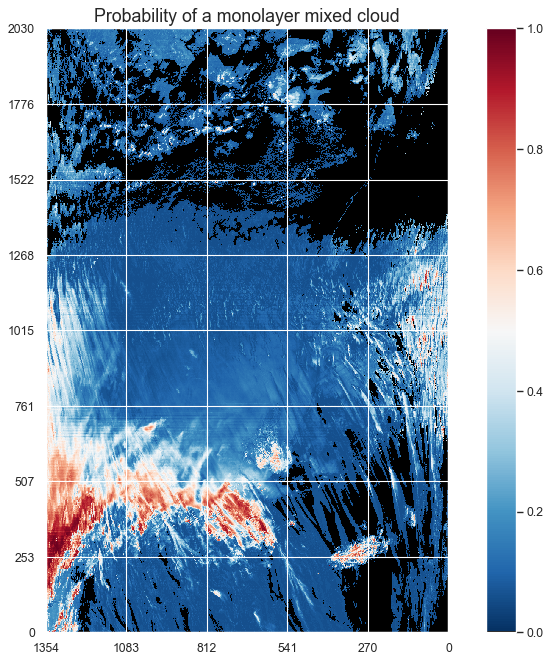

In [418]:
modis_y_prob = np.zeros((cloud_mask_flag.shape)) 
modis_y_prob[row,col] = monolayer_mixed_model_y_prob[:,0]
plot_y_prob(modis_y_prob, 'Probability of a monolayer mixed cloud')

In [420]:
X = pd.DataFrame(data=X, columns=features_train)

X_scaled = ice_liquid_scaled_data(X)

In [421]:
%%time

multilayer_ice_liquid_model_y_prob = multilayer_ice_liquid_model.predict(X_scaled)

CPU times: user 45.8 s, sys: 2.82 s, total: 48.6 s
Wall time: 35.5 s


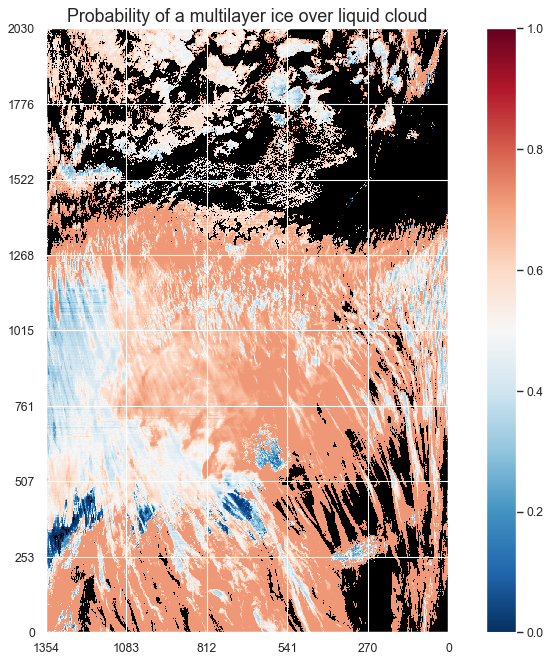

In [422]:
modis_y_prob = np.zeros((cloud_mask_flag.shape)) 
modis_y_prob[row,col] = multilayer_ice_liquid_model_y_prob[:,0]
plot_y_prob(modis_y_prob, 'Probability of a multilayer ice over liquid cloud')

In [712]:
df = pd.read_csv('../data/2008_01_colocated_modis_caliop_cloudsat_random_sample_dataset.csv',index_col=False)

print('dataframe shape',df.shape)

dataframe shape (155000, 113)


In [713]:
df['label 1'] = 'unlabeled'
df['label 2'] = 'unlabeled'

#print(df.head())

for index, row in df.iterrows():
    nb_cloud_layer = 0
    cloud_phase_per_layer_list = []
    for layer_idx in range(10):
        if int( row['cloud_layer_source_{:02d}'.format(layer_idx+1)] ) == 3: # cldclass-lidar product
            cloud_phase_per_layer_list.append( int( row['cloud_layer_phase_{:02d}'.format(layer_idx+1)] ) )
            nb_cloud_layer = nb_cloud_layer + 1
    if nb_cloud_layer == 1: # monolayer cloud   
        df.loc[index,'label 1'] = 'monolayer (n=1)'
        if cloud_phase_per_layer_list[0] == 1: df.loc[index,'label 2'] = 'ice'
        if cloud_phase_per_layer_list[0] == 2: df.loc[index,'label 2'] = 'mixed'    
        if cloud_phase_per_layer_list[0] == 3: df.loc[index,'label 2'] = 'liquid'
    if nb_cloud_layer == 2: # multilayer cloud 
        df.loc[index,'label 1'] = 'multilayer (n=2)'
        if cloud_phase_per_layer_list[0] == 1 and cloud_phase_per_layer_list[1] == 1: 
            df.loc[index,'label 2'] = 'ice / ice'
        if cloud_phase_per_layer_list[0] == 1 and cloud_phase_per_layer_list[1] == 3: 
            df.loc[index,'label 2'] = 'ice / liquid'
        if cloud_phase_per_layer_list[0] == 1 and cloud_phase_per_layer_list[1] == 2: 
            df.loc[index,'label 2'] = 'ice / mixed'
        if cloud_phase_per_layer_list[0] == 3 and cloud_phase_per_layer_list[1] == 3: 
            df.loc[index,'label 2'] = 'liquid / liquid'
        if cloud_phase_per_layer_list[0] == 2 and cloud_phase_per_layer_list[1] == 3: 
            df.loc[index,'label 2'] = 'mixed / liquid'    
        if cloud_phase_per_layer_list[0] == 3 and cloud_phase_per_layer_list[1] == 1: 
            df.loc[index,'label 2'] = 'liquid / ice'
    if nb_cloud_layer > 2: # multilayer cloud 
        df.loc[index,'label 1'] = 'multilayer (n>2)'

In [776]:
df['modis_cloud_phase']

0         2.0
1         2.0
2         2.0
3         2.0
4         2.0
         ... 
154995    2.0
154996    4.0
154997    2.0
154998    2.0
154999    2.0
Name: modis_cloud_phase, Length: 155000, dtype: float64

In [777]:
#modis_cloud_phase modis_cloud_effective_radius

df_liquid_re = df[ (df.modis_cloud_phase == 2.0) & (df.modis_cloud_effective_radius > 0.) ]

df_liquid_re['modis_cloud_effective_radius'] = df_liquid_re['modis_cloud_effective_radius'] * 0.01

In [778]:
df_liquid_re.columns

Index(['modis_multilayer_cloud', 'modis_multilayer_cloud_qa1',
       'modis_multilayer_cloud_qa2', 'modis_multilayer_cloud_qa3',
       'modis_multilayer_cloud_qa4', 'modis_multilayer_cloud_qa5',
       'modis_cloud_phase', 'latitude', 'longitude',
       'modis_cloud_top_height_1km',
       ...
       'cloud_layer_optical_depth_09', 'cloud_layer_phase_09',
       'cloud_layer_source_09', 'cloud_layer_top_10', 'cloud_layer_base_10',
       'cloud_layer_optical_depth_10', 'cloud_layer_phase_10',
       'cloud_layer_source_10', 'label 1', 'label 2'],
      dtype='object', length=115)

In [779]:
df_liquid_re_monolayer = df_liquid_re[ df_liquid_re['label 1'] == 'monolayer (n=1)' ] 
df_liquid_re_multilayer = df_liquid_re[ df_liquid_re['label 1'] != 'monolayer (n=1)' ] 

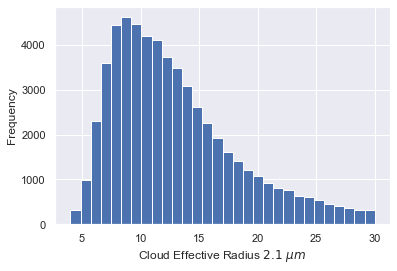

In [794]:
df_liquid_re['modis_cloud_effective_radius'].plot(kind='hist',bins=30)

plt.xlabel(u'Cloud Effective Radius $2.1 \ \mu m$')


plt.show()

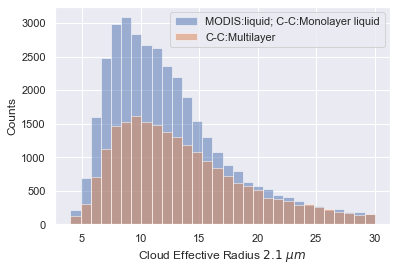

In [801]:
df_liquid_re_monolayer['modis_cloud_effective_radius'].plot(kind='hist',bins=30,density=0, alpha=0.5, label='MODIS:liquid; C-C:Monolayer liquid')
df_liquid_re_multilayer['modis_cloud_effective_radius'].plot(kind='hist',bins=30,density=0, alpha=0.5, label='C-C:Multilayer')

plt.legend()

plt.xlabel(u'Cloud Effective Radius $2.1 \ \mu m$')
plt.ylabel('Counts')

plt.show()

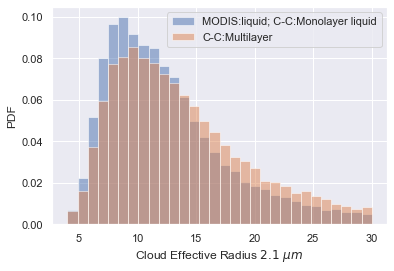

In [802]:
df_liquid_re_monolayer['modis_cloud_effective_radius'].plot(kind='hist',bins=30,density=1, alpha=0.5, label='MODIS:liquid; C-C:Monolayer liquid')
df_liquid_re_multilayer['modis_cloud_effective_radius'].plot(kind='hist',bins=30,density=1, alpha=0.5, label='C-C:Multilayer')

plt.legend()

plt.xlabel(u'Cloud Effective Radius $2.1 \ \mu m$')
plt.ylabel('PDF')

plt.show()

In [783]:
%%time

features_list = ['modis_band_1','modis_band_7','modis_band_20',
                 'modis_band_26','modis_band_28','modis_band_29',
                 'modis_band_31','modis_band_32']

X0 = df_liquid_re_monolayer[features_list]
X1 = df_liquid_re_multilayer[features_list]

X0_scaled = liquid_scaled_data(X0)
X1_scaled = liquid_scaled_data(X1)

yhat0 = monolayer_liquid_model.predict(X0_scaled)
yhat1 = monolayer_liquid_model.predict(X1_scaled)

CPU times: user 1.24 s, sys: 75.6 ms, total: 1.32 s
Wall time: 903 ms


In [784]:
df0_yhat = pd.DataFrame(yhat0,index=df_liquid_re_monolayer.index, columns=['yhat'])
df1_yhat = pd.DataFrame(yhat1,index=df_liquid_re_multilayer.index, columns=['yhat'])

In [785]:
liquid_test0 = pd.concat([df_liquid_re_monolayer, df0_yhat], axis=1, sort=True)
liquid_test1 = pd.concat([df_liquid_re_multilayer, df1_yhat], axis=1, sort=True)

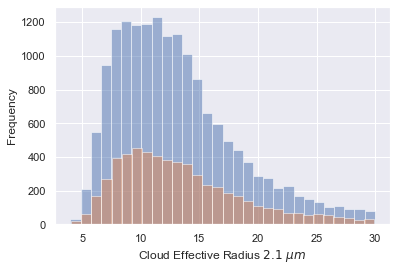

In [786]:
liquid_test0['modis_cloud_effective_radius'][ liquid_test0['yhat'] > 0.7 ].plot(kind='hist',bins=30,density=0, alpha=0.5)
liquid_test1['modis_cloud_effective_radius'][ liquid_test1['yhat'] > 0.7 ].plot(kind='hist',bins=30,density=0, alpha=0.5)

plt.xlabel(u'Cloud Effective Radius $2.1 \ \mu m$')


plt.show()

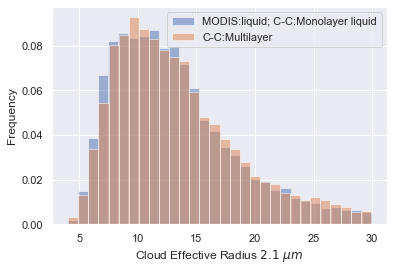

In [797]:
liquid_test0['modis_cloud_effective_radius'][ liquid_test0['yhat'] > 0.7 ].plot(kind='hist',bins=30,density=1, alpha=0.5, label='MODIS:liquid; C-C:Monolayer liquid')
liquid_test1['modis_cloud_effective_radius'][ liquid_test1['yhat'] > 0.7 ].plot(kind='hist',bins=30,density=1, alpha=0.5, label='C-C:Multilayer')

plt.xlabel(u'Cloud Effective Radius $2.1 \ \mu m$')

plt.legend()

plt.show()

In [788]:
#modis_cloud_phase modis_cloud_effective_radius

df_ice_re = df[ (df.modis_cloud_phase == 3.0) & (df.modis_cloud_effective_radius > 0.) ]

df_ice_re['modis_cloud_effective_radius'] = df_ice_re['modis_cloud_effective_radius'] * 0.01

In [789]:
df_ice_re_monolayer = df_ice_re[ df_ice_re['label 1'] == 'monolayer (n=1)' ] 
df_ice_re_multilayer = df_ice_re[ df_ice_re['label 1'] != 'monolayer (n=1)' ] 

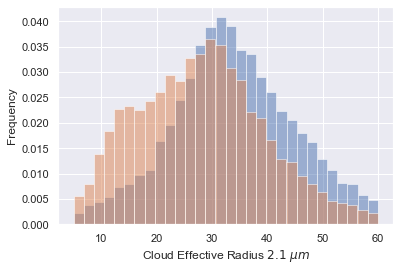

In [790]:
df_ice_re_monolayer['modis_cloud_effective_radius'].plot(kind='hist',bins=30,density=1, alpha=0.5)
df_ice_re_multilayer['modis_cloud_effective_radius'].plot(kind='hist',bins=30,density=1, alpha=0.5)

plt.xlabel(u'Cloud Effective Radius $2.1 \ \mu m$')

plt.show()

In [791]:
%%time

features_list = ['modis_band_1','modis_band_7','modis_band_20',
                 'modis_band_26','modis_band_28','modis_band_29',
                 'modis_band_31','modis_band_32']

X0 = df_ice_re_monolayer[features_list]
X1 = df_ice_re_multilayer[features_list]

X0_scaled = ice_scaled_data(X0)
X1_scaled = ice_scaled_data(X1)

yhat0 = monolayer_ice_model.predict(X0_scaled)
yhat1 = monolayer_ice_model.predict(X1_scaled)

CPU times: user 826 ms, sys: 52.4 ms, total: 879 ms
Wall time: 620 ms


In [792]:
df0_yhat = pd.DataFrame(yhat0,index=df_ice_re_monolayer.index, columns=['yhat'])
df1_yhat = pd.DataFrame(yhat1,index=df_ice_re_multilayer.index, columns=['yhat'])

test0 = pd.concat([df_ice_re_monolayer, df0_yhat], axis=1, sort=True)
test1 = pd.concat([df_ice_re_multilayer, df1_yhat], axis=1, sort=True)

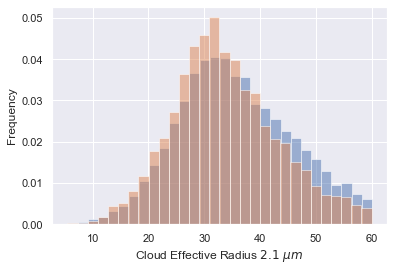

In [804]:
test0['modis_cloud_effective_radius'][ test0['yhat'] > 0.7 ].plot(kind='hist',bins=30,density=1, alpha=0.5)
test1['modis_cloud_effective_radius'][ test1['yhat'] > 0.7 ].plot(kind='hist',bins=30,density=1, alpha=0.5)

plt.xlabel(u'Cloud Effective Radius $2.1 \ \mu m$')


plt.show()

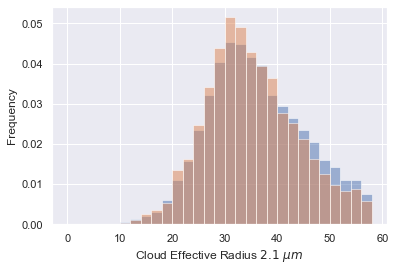

In [808]:
test0['modis_cloud_effective_radius'][ test0['yhat'] > 0.85 ].plot(kind='hist',bins=[i*2 for i in range(30)],density=1, alpha=0.5)
test1['modis_cloud_effective_radius'][ test1['yhat'] > 0.85 ].plot(kind='hist',bins=[i*2 for i in range(30)],density=1, alpha=0.5)

plt.xlabel(u'Cloud Effective Radius $2.1 \ \mu m$')


plt.show()